# Group Members
1. Chetna Singhal (cs57926)
2. David Kinman
3. Prajval Gupta
4. Subhayu Chakravarty
5. Whitt Hyde

In [3]:
from selenium import webdriver
import pandas as pd

In [17]:
driver = webdriver.Chrome(executable_path='/Users/subhayuchakravarty/Downloads/chromedriver')

comments = pd.DataFrame(columns = ['Date','user_id','comments']) 

for i in range(723,550,-1):
    driver.get('https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p'+ str(i))

    ids = driver.find_elements_by_xpath("//*[contains(@id,'Comment_')]")
    comment_ids = []
    for i in ids:
        comment_ids.append(i.get_attribute('id'))

    for x in comment_ids:
        #Extract dates from for each user on a page
        user_date = driver.find_elements_by_xpath('//*[@id="' + x +'"]/div/div[2]/div[2]/span[1]/a/time')[0]
        date = user_date.get_attribute('title')
        
        #Extract user ids from each user on a page
        userid_element = driver.find_elements_by_xpath('//*[@id="' + x +'"]/div/div[2]/div[1]/span[1]/a[2]')[0]
        userid = userid_element.text
        
        #Extract Message for each user on a page
        user_message = driver.find_elements_by_xpath('//*[@id="' + x +'"]/div/div[3]/div/div[1]')[0]
        comment = user_message.text
        
        #Removing block quotes
        total_msg = driver.find_element_by_xpath('//*[@id="' + x + '"]/div/div[3]/div/div[1]')
        block_msg = total_msg.find_elements_by_class_name('UserQuote')
        if block_msg:
            comment = comment.replace(block_msg[0].text,"")
            
        #Adding date, userid and comment for each user in a dataframe    
        comments.loc[len(comments)] = [date,userid,comment]

NameError: name 'pd' is not defined

In [ ]:
print(comments.shape)
comments.to_csv("posts1.csv", encoding='utf-8')

### Part 3 - Data Cleansing

In [4]:
from time import sleep
from selenium import webdriver
from string import punctuation
import re
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import copy
import matplotlib.pyplot as plt
%pylab inline
import numpy as np
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


/Users/subhayuchakravarty/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [5]:
# Load user comments into a dataframe
df = pd.read_csv("posts.csv", usecols=["comments"])
df.columns = ["Posts"]

In [6]:
df.head()

,Posts
0,\nWe'd high speed nissanion still have the A4....
1,"well, the Hyundai BtoB is transferable and tha..."
2,\nLots of 2019's left right now though.
3,I should go see what they will offer on a lease!
4,I just did the opposite. After nearly 10 years...


In [7]:
# Remove newline from each post & drop rows with null values
df = df.replace('\n','', regex=True)
df = df.dropna()

In [8]:
df.head()

,Posts
0,We'd high speed nissanion still have the A4......
1,"well, the Hyundai BtoB is transferable and tha..."
2,Lots of 2019's left right now though.
3,I should go see what they will offer on a lease!
4,I just did the opposite. After nearly 10 years...


In [9]:
df["Post Length"]= df["Posts"].str.len() 
df.head()

,Posts,Post Length
0,We'd high speed nissanion still have the A4......,285
1,"well, the Hyundai BtoB is transferable and tha...",124
2,Lots of 2019's left right now though.,37
3,I should go see what they will offer on a lease!,48
4,I just did the opposite. After nearly 10 years...,206


In [10]:
# Remove all punctuation characters from each post and convert text to lowercase for efficient frequency counting
# punctuation includes !"#$%&'()*+, -./:;<=>?@[\]^_`{|}~

def remove_punctuations(item):
    for p in punctuation:
        item = item.strip().replace(p,'')
    return item

df["Posts"] = df['Posts'].apply(remove_punctuations)
df['Posts'] = df["Posts"].apply(lambda x: x.lower())
df["Post Length"]= df["Posts"].str.len() 
df.head()

,Posts,Post Length
0,wed high speed nissanion still have the a4 4 c...,269
1,well the hyundai btob is transferable and that...,118
2,lots of 2019s left right now though,35
3,i should go see what they will offer on a lease,47
4,i just did the opposite after nearly 10 years ...,203


In [11]:
# Replace car models with brand names for effective analysis - Part A

models = pd.read_csv("models.csv", header = 0, names = ['Brand','Model'],encoding='windows-1252')
models['Brand'] = models['Brand'].str.strip(punctuation)
models.head()

,Brand,Model
0,acura,acura-s
1,acura,ilx
2,acura,integra
3,acura,legend
4,acura,mdx


In [12]:
# Replace car models with brand names for effective analysis - Part B

def model_to_brand(s):
    for i in models.index.values:
        s = s.replace(models["Model"][i].lower(),models["Brand"][i].lower())
    return s

df['Posts'] = df['Posts'].apply(model_to_brand)

In [13]:
df["Post Length"]= df["Posts"].str.len() 
df.head()

,Posts,Post Length
0,wed high speed nissanion still have the audi 4...,273
1,well the hyundai btob is transferable and that...,126
2,lots of 2019s left right now though,35
3,i should go see what they will offer on a lease,47
4,i just did the opposite after nearly 10 years ...,203


In [14]:
# Remove stopwords - Part A
# nltk.download('stopwords')

df['Tokens'] = df['Posts'].apply(word_tokenize).apply(set).apply(list)
stop_words = set(stopwords.words('english'))
df.head()

,Posts,Post Length,Tokens
0,wed high speed nissanion still have the audi 4...,273,"[need, high, wed, cars, way, at, schedule, thi..."
1,well the hyundai btob is transferable and that...,126,"[that, different, anyway, is, transferable, on..."
2,lots of 2019s left right now though,35,"[lots, now, of, though, right, 2019s, left]"
3,i should go see what they will offer on a lease,47,"[lease, what, see, on, they, will, go, a, shou..."
4,i just did the opposite after nearly 10 years ...,203,"[or, nearly, on, listens, separate, 80s, did, ..."


In [15]:
# Remove stopwords - Part B

def remove_stopwords(s):
    return [w for w in s if not w in stop_words] 
    
df['Tokens'] = df['Tokens'].apply(remove_stopwords)
df.replace({'beaudier': 'audi', 'preaudiy':'audi', 'geaudiing':'audi', 'audi0':'audi', 'maaudier':'audi'}, inplace=True)
df.replace({'acurax': 'acura', 'litacurae':'acura', 'exacacuray':'acura', 'acuras':'acura', 'recenacuray':'acura', 'mosacuray':'acura', 'apparenacuray':'acura'}, inplace=True)
df.replace({'thcadillac': 'cadillac', 'secadillac':'cadillac'}, inplace=True)
df.replace({'beaudier': 'bmw'}, inplace=True)
df.replace({'mercedesss': 'mercedes', 'rememercedeser':'mercedes', 'numercedeser':'mercedes', 'numercedesers':'mercedes'}, inplace=True)
df.replace({'nissanion': 'nissan'}, inplace=True)

df.head()

,Posts,Post Length,Tokens
0,wed high speed nissanion still have the audi 4...,273,"[need, high, wed, cars, way, schedule, audi, s..."
1,well the hyundai btob is transferable and that...,126,"[different, anyway, transferable, 672, 560, di..."
2,lots of 2019s left right now though,35,"[lots, though, right, 2019s, left]"
3,i should go see what they will offer on a lease,47,"[lease, see, go, offer]"
4,i just did the opposite after nearly 10 years ...,203,"[nearly, listens, separate, 80s, together, yea..."


### Count word frequency

In [194]:
count = []

for i in range(len(df['Tokens'])):
    count += df.iloc[i]['Tokens']

for n, i in enumerate(count):
    if count[n] in ['beaudier', 'preaudiy', 'geaudiing', 'audi0', 'maaudier']:
        count[n] = 'audi'
    if count[n] in ['acurax', 'litacurae', 'exacacuray', 'acuras', 'recenacuray', 'mosacuray', 'apparenacuray']:
        count[n] = 'acura'
    if count[n] in ['thcadillac', 'secadillac']:
        count[n] = 'cadillac'
    if count[n] in ['bmwi']:
        count[n] = 'bmw'
    if count[n] in ['mercedesss', 'rememercedeser', 'numercedeser', 'numercedesers']:
        count[n] = 'mercedes'
    if count[n] in ['nissanion']:
        count[n] = 'nissan'
        
from nltk import FreqDist
word_freq = nltk.FreqDist(count)

#print(count)
word_freq

FreqDist({'audi': 2230, 'acura': 1571, 'bmw': 1514, 'car': 1496, 'like': 1203, 'one': 1084, 'would': 1075, 'cars': 943, 'get': 932, 'new': 877, ...})

In [195]:
top_words = word_freq.most_common(500)

top_words

[('audi', 2230),
 ('acura', 1571),
 ('bmw', 1514),
 ('car', 1496),
 ('like', 1203),
 ('one', 1084),
 ('would', 1075),
 ('cars', 943),
 ('get', 932),
 ('new', 877),
 ('think', 872),
 ('mercedes', 871),
 ('cadillac', 832),
 ('dont', 774),
 ('even', 721),
 ('good', 689),
 ('well', 686),
 ('im', 668),
 ('much', 635),
 ('really', 621),
 ('time', 600),
 ('still', 562),
 ('know', 561),
 ('could', 538),
 ('drive', 531),
 ('also', 520),
 ('years', 495),
 ('go', 492),
 ('see', 472),
 ('want', 458),
 ('price', 449),
 ('way', 441),
 ('make', 438),
 ('people', 436),
 ('back', 432),
 ('going', 419),
 ('say', 396),
 ('dealer', 391),
 ('probably', 388),
 ('many', 382),
 ('nice', 376),
 ('less', 372),
 ('take', 371),
 ('seems', 368),
 ('lot', 361),
 ('since', 358),
 ('driving', 355),
 ('honda', 352),
 ('miles', 351),
 ('sure', 351),
 ('got', 350),
 ('right', 348),
 ('thing', 345),
 ('something', 344),
 ('first', 338),
 ('least', 337),
 ('said', 335),
 ('year', 333),
 ('used', 327),
 ('doesnt', 325),
 (

## Task A
### Find top 10 brands

In [196]:
top_brands_count = []

models_unique = models['Brand'].drop_duplicates().tolist()

for (key, items) in top_words:
    if key in models_unique:
        model_count = (key,items)
        top_brands_count.append(model_count)  

print ('Top 10 brands along with their frequencies\n' , top_brands_count[:10])

Top 10 brands along with their frequencies
 [('audi', 2230), ('acura', 1571), ('bmw', 1514), ('mercedes', 871), ('cadillac', 832), ('honda', 352), ('ford', 241), ('volkswagen', 228), ('hyundai', 196), ('infiniti', 189)]


### Calculate Lift Ratios for Top 10 brands 

In [197]:
# Create a new dataframe to store occurence of each brand in top 10 list in each post

top_brands =[]
for brand, count in top_brands_count[:10]:
    top_brands.append(brand) 

brand_df = pd.DataFrame(columns = top_brands)
top_brands

['audi',
 'acura',
 'bmw',
 'mercedes',
 'cadillac',
 'honda',
 'ford',
 'volkswagen',
 'hyundai',
 'infiniti']

In [198]:
def brand_count(item):
    if brand in item:
        return 1
    else:
        return 0
      
for brand in top_brands:
    brand_df[brand] = df['Posts'].apply(brand_count)    
    
brand_df

,audi,acura,bmw,mercedes,cadillac,honda,ford,volkswagen,hyundai,infiniti
0,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,1,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0
6,0,1,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0
9,0,1,0,0,0,0,0,0,0,0


In [199]:
lift_df = pd.DataFrame(columns = top_brands)

for i in range(len(top_brands)):
    new_list = []
    for j in range(len(top_brands)):
        if (i!=j):
            num = ((brand_df[top_brands[i]] + brand_df[top_brands[j]]) > 1).sum()
            dem = brand_df[top_brands[j]].sum()*brand_df[top_brands[i]].sum()
            lift = num * len(brand_df) / dem
            lift_df.loc[top_brands[i],top_brands[j]] = lift

print ('Lift Matrix\n')
lift_df

Lift Matrix



,audi,acura,bmw,mercedes,cadillac,honda,ford,volkswagen,hyundai,infiniti
audi,NaN,1.43729,1.31612,1.53171,1.48911,1.5739,1.36193,1.5744,1.46138,1.75311
acura,1.43729,NaN,1.23855,1.63133,1.58104,2.18171,1.50452,1.38707,1.44131,2.0863
bmw,1.31612,1.23855,NaN,1.61323,1.42986,1.25715,1.53684,1.13669,1.3795,1.96355
mercedes,1.53171,1.63133,1.61323,NaN,1.70739,1.8839,1.64158,1.66795,1.48302,2.39875
cadillac,1.48911,1.58104,1.42986,1.70739,NaN,1.3974,1.38036,1.18735,1.59556,2.13836
honda,1.5739,2.18171,1.25715,1.8839,1.3974,NaN,1.80504,2.03829,1.83158,2.0244
ford,1.36193,1.50452,1.53684,1.64158,1.38036,1.80504,NaN,1.92898,2.15295,1.68545
volkswagen,1.5744,1.38707,1.13669,1.66795,1.18735,2.03829,1.92898,NaN,1.49904,1.86276
hyundai,1.46138,1.44131,1.3795,1.48302,1.59556,1.83158,2.15295,1.49904,NaN,2.2756
infiniti,1.75311,2.0863,1.96355,2.39875,2.13836,2.0244,1.68545,1.86276,2.2756,NaN


### Multi-Dimensional Scaling (MDS) map

In [200]:
# Calculating the dissimilarity matrix which is the input for plotting MDS plot

lift_inverse_df = 1/lift_df
np.fill_diagonal(lift_inverse_df.values, 0)

lift_inverse_df

,audi,acura,bmw,mercedes,cadillac,honda,ford,volkswagen,hyundai,infiniti
audi,0,0.695752,0.759807,0.652865,0.671542,0.635362,0.734253,0.635161,0.684286,0.570416
acura,0.695752,0,0.807393,0.612997,0.632495,0.458355,0.664666,0.720945,0.693811,0.479317
bmw,0.759807,0.807393,0,0.619875,0.699371,0.795451,0.650688,0.879746,0.724901,0.509283
mercedes,0.652865,0.612997,0.619875,0,0.58569,0.530815,0.609171,0.599538,0.674298,0.416884
cadillac,0.671542,0.632495,0.699371,0.58569,0,0.715617,0.724449,0.84221,0.62674,0.467649
honda,0.635362,0.458355,0.795451,0.530815,0.715617,0,0.554004,0.490607,0.545976,0.493974
ford,0.734253,0.664666,0.650688,0.609171,0.724449,0.554004,0,0.518409,0.464479,0.593313
volkswagen,0.635161,0.720945,0.879746,0.599538,0.84221,0.490607,0.518409,0,0.667092,0.536839
hyundai,0.684286,0.693811,0.724901,0.674298,0.62674,0.545976,0.464479,0.667092,0,0.439444
infiniti,0.570416,0.479317,0.509283,0.416884,0.467649,0.493974,0.593313,0.536839,0.439444,0


In [168]:
from sklearn import manifold

seed = np.random.RandomState(seed=3)

mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=seed,
                   dissimilarity="precomputed", n_jobs=1)
pos = mds.fit_transform(lift_inverse_df)

plt.subplots_adjust(bottom = 0.1)
plt.scatter(
    coords[:, 0], coords[:, 1], marker = 'o'
    )
for label, x, y in zip(top_brands, pos[:, 0], pos[:, 1]):
    
    plt.annotate(
        label,
        xy = (x, y), xytext = (-5, 5),
        textcoords = 'offset points', ha = 'right', va = 'bottom')

plt.show()

NameError: name 'coords' is not defined

<Figure size 432x288 with 0 Axes>

# Task B: 

What insights can you offer brand managers from your analysis in Task A (choose two brands that you can offer the most interesting/useful insights for)? 

### I. Ford
In our lift analysis we found two very strong trends regarding the American auto company based in Detroit: 
- They are mentioned most with foreign (non-American) brands
- Hyundai presents the biggest competition for Ford

#### Foreign Brands
First, Ford finds itself in an interesting position as the American company that prides itself on being America's leading producers of automobiles finds its brand most closely related to foreign companies. This could mean one of two things: either Ford's campaign to establish itself as "America's car manufacturer" is not working, or the push for an "American" image is inconsequential to the consumer when considering the vehicle.

##### American Image
Let's take the first scenario into account. If it is indeed the case that Ford's marketing campaigns are ineffective at portraying the brand as domestic, then I would advise brand managers to adjust advertising to make a stronger push to the patriotic appeal. Then, after ajusting the marketing strategies you could run the lift analysis once more to see if Ford's lift values are more aligned with other domestic brands as well as comparing overall sales figures to make. 

##### Other Explanation
However, it is important to consider the context of the study (Entry Level Luxury Sedans). Ford has always been a leader in the pickup truck industry, and pickup trucks are a very American product, thus it is important to truck consumers that their truck is "American". But perhaps it is more likely that the consumer of a luxury sedan does not care as much about the vehicle being "American Made", but rather consider other features (such as safety for instance) as more important. The answer to this question relies in the competition for Ford.

#### Hyundai and Volkswagen Competition
It is likely that this high relation and lift with these foreign brands is due to another feature. When we look to the closest brands in lift we see Ford lines up against Hyundai and Volkswagen. The sedans for those two brands - The "Hyundai Elantra" and "Volkswagen Jetta" are known for their reliability for a reasonable price. This makes sense for Ford historically, as they have been leaders on durability and longevity in their vehicles. With this in mind, there are two steps stragetically that I can see success moving forward: become the sole leader in reliability, or add another key feature of their vehicle. 

### Recommendation to Ford's Brand Manager

Ford should take the following steps:
1. Make a stronger pursuit in establishing itself in its competitive positioning as "The American" Brand. They can do this through adverstising campaigns on the national level, while appealling to luxury car consumers emotional patriotic side. Luxury consumers are inherently by definition willing to spend a little more. Ford should first do their own analysis to make sure this is in fact something their customer cares about, then continue to highlight its American features.
2. Ford should expand its core competancies. Ford has always been known as a very reliable brand and that's a great thing. However I believe it would do Ford to expand upon this and enter a more niche speciality. For instance, they could become the world's most reliable "green car", or most reliable "comfort ride." This is important because right now they stand in line with their competition Hyundai and Volkswagen. If they cannot do something to differentiate in brand, they will likely lose customers to the other two if they were to offer a slightly lower price.  


### II. Mercedes

After our lift analysis we found that Mercedes entry level sedans are on an island with the Japanese Infiniti brand with a lift value of 2.39. It is possible this lift value is high for two reasons:  
- Mercedes and Infiniti are both known as unreliable relative to other luxury brands 
- The competitive landscape between the two is close, and this should raise alarms for Mercedes

#### Reliability Issue
One explanation to the strong connection between Infiniti and Mercedes is the reliability problem that has plagued both brands. Consumer Reports marked the Infiniti Q50 as one of the least reliable luxury cars on the market back in 2014. They reported that it was 127% less reliable than the average. In 2014, Consumer Reports also reported that the Mercedes CLA was not only the most unreliable Mercedes in the Auto Reliability Survey, but 140% worse than the average car. So, in otherwords both brands have a big issue on their hand when it comes to public opinion and reliability

(References: https://www.osv.ltd.uk/are-mercedes-benz-reliable/ , and https://www.osv.ltd.uk/are-infiniti-reliable/ )

#### Mercedes Competition with Infiniti
Mercedes and Infiniti's core market is luxury vehicles and as such they will share a lot of the same battlegrounds. In fact, Infiniti's Q Models, and Mercedes-Benz's C-Class are direct competitors in the entry level luxury sedan field that share a lot of similiarities. However there are slight differences in the models that highlight the overall sentiments of the brands. Mercedes' C-Class delivers more power, it also has a more safety feature, and it even gives a more economic fuel efficient ride. 

(References: https://www.autotrader.com/car-reviews/2017-infiniti-q60-vs-2017-mercedes-benz-c-class-coupe-which-better-258411 )

###### So why are these brands so closely related then???

This golden question is one that needs to be answered fast by the brand managers at Mercedes. In my opinion, the brand needs to realign itself to the market of upper-luxury and stick to its core competancy. There are many different levels of C-Class Mercedes, wherein the more you spend -> the better performing model you get. This is done to be competitive at all the levels of the market. Take for instance the Mercedes C300 model, it is the cheapest in the C-Class, and it is made this way so Mercedes can sell to the lower end of the luxury model. 

### Recommendation for Mercedes Brand Manager
The brand manager needs to distance themself from Infiniti. In order to do this, they must accomplish a few things:
1. First, they must revamp marketing to show the superior features that one gets when they choose Mercedes. 
2. Second, they must work to remove the stigma of Mercedes' reliability (or lack thereof). They do not need to become leaders in reliability, however they must raise the bar from where it stands today. 
3. Third, I recommend they pull out of the lower-entry level of luxury. While selling the C300 model allows them to reach another customer base, it is opening up the opportunities to compare them to other brands in that market (namely Infiniti). The Infiniti Q60 is no where close to the car that the C43 Mercedes is, but they aren't close in price either. However, it is clear based on the high lift of 2.39 the two brands are being compared and talked about in union. I believe this is a byproduct of Merecedes entering this market with the C300. I would recommend Mercedes pull the C300, and focus on the market of car that has made them famous.

## Task C

### Attribute - Brand Association

In [16]:
import matplotlib.pyplot as plt
from itertools import groupby
from collections import Counter
from nltk import ngrams, FreqDist
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, webtext

In [17]:
df_a=df.copy()
df_a=df_a.drop(['Tokens'], axis=1)
df_a.head()

,Posts,Post Length
0,wed high speed nissanion still have the audi 4...,273
1,well the hyundai btob is transferable and that...,126
2,lots of 2019s left right now though,35
3,i should go see what they will offer on a lease,47
4,i just did the opposite after nearly 10 years ...,203


In [18]:
def model_to_capbrand(s):
    for i in models.index.values:
        if models["Brand"][i].lower() in s:
            s = s.replace(models["Brand"][i].lower(),models["Brand"][i].upper())
            continue
    return s



In [19]:
df_a.head()

,Posts,Post Length
0,wed high speed nissanion still have the audi 4...,273
1,well the hyundai btob is transferable and that...,126
2,lots of 2019s left right now though,35
3,i should go see what they will offer on a lease,47
4,i just did the opposite after nearly 10 years ...,203


In [20]:
# Synonymous words for replacement
performwords={'powerful':'performance','power':'performance',
              'mileage':'performance','speed':'performance',
              'fast':'performance','transmission':'performance',
              'engine':'performance','suspension':'performance','sport':'performance',
             'high performance':'performance',
              'quick':'performance',
              'good horsepower':'performance',
              'exotic':'performance',
              'excellent':'performance',
              'fuel efficient':'performance',
              'high fuel economy':'performance',
              'high mpg':'performance',
              'good mpg':'performance',
              'good fuel economy':'performance',
              'responsive':'performance',
              'tough':'performance',
              'reliable':'performance'}
#use style 
stylewords={'look':'style','looks':'style','stylish':'style',
            'gorgeous':'style','classy':'style','beauty':'style',
            'good looking':'style',
            'modern':'style','sleek':'style'}


#use luxury
luxurywords={'highend':'luxury','high end':'luxury',
             'luxurious':'luxury','expensive':'luxury',
             'fancy':'luxury','fancier':'luxury',
             'grand':'luxury', 'high-end':'style'}
#Use comfort
comfortwords={'comfortable':'comfort','convenience':'comfort',
              'convenient':'comfort','comfy':'comfort',
              'cozy':'comfort','good cup holders':'comfort','spacious cup holders':'comfort',
              'good cup-holders':'comfort','spacious cup-holders':'comfort'}
#use price
costwords={'cheap':'price','prices':'price',
           'pricing':'price','economic':'price',
           'costeffective':'price','lease':'price',
           'rent':'price','money':'price',
           'good price':'price','good pricing':'price',
           'good listing':'price','sale':'price',
           'economical':'price','affordable':'price',
           'cost-effective':'price','cost effective':'price'
          
          }
#usespace
bigwords={'big':'space','wide':'space','wider':'space',
          'bigger':'space','larger':'space','spacious':'space',
          'huge':'space','legspace':'space',
          'bigger':'space','large':'space',
          'leg-space':'space','leg room':'space',
          'open':'space'        
         }
#use safety
safewords={'safe':'safety','safer':'safety','tested':'safety',
           'test':'safety','crash-test':'safety','crash test':'safety',
           'safety score':'safety','reliable':'safety',
           'reliability':'safety'
          }

# influencewords={'wife':'influence','family':'influence','relative':'influence','relatives':'influence','cousin':'influencer'}


In [21]:
df_a['Posts'].replace({'beaudier': 'AUDI', 'preaudiy':'AUDI', 'geaudiing':'AUDI', 'audi0':'AUDI', 'maaudier':'AUDI'}, inplace=True, regex=True)
df_a['Posts'].replace({'acurax': 'ACURA', 'litacurae':'ACURA', 'exacacuray':'ACURA', 'acuras':'ACURA', 'recenacuray':'ACURA', 'mosacuray':'ACURA', 'apparenacuray':'ACURA', '’':''}, inplace=True, regex=True)
df_a['Posts'].replace({'thcadillac': 'CADILLAC', 'secadillac':'CADILLAC'}, inplace=True, regex=True)
df_a['Posts'].replace({'beaudier': 'BMW','bmwi':'BMW'}, inplace=True, regex=True)
df_a['Posts'].replace({'mercedess': 'MERCEDES','mercedesss': 'MERCEDES', 'rememercedeser':'MERCEDES', 'numercedeser':'MERCEDES', 'numercedesers':'MERCEDES'}, inplace=True, regex=True)
df_a['Posts'].replace({'nissanion': 'NISSAN'}, inplace=True, regex=True)

df_a['Posts'].replace(performwords, inplace=True, regex=True)
df_a['Posts'].replace(stylewords, inplace=True, regex=True)
df_a['Posts'].replace(luxurywords, inplace=True, regex=True)
df_a['Posts'].replace(costwords, inplace=True, regex=True)
df_a['Posts'].replace(bigwords, inplace=True, regex=True)
df_a['Posts'].replace(safewords, inplace=True, regex=True)
df_a['Posts'].replace(comfortwords, inplace=True, regex=True)
# df_a['Posts'].replace(influencewords, inplace=True, regex=True)


In [22]:
df_a['Posts'] = df_a['Posts'].apply(model_to_capbrand)

In [23]:
df_a.head()

,Posts,Post Length
0,wed high performance NISSAN still have the AUD...,273
1,well the HYUNDAI btob is transferable and that...,126
2,lots of 2019s left right now though,35
3,i should go see what they will offer on a price,47
4,i just did the opposite after nearly 10 years ...,203


In [24]:
df_a['Tokens'] = df_a['Posts'].apply(word_tokenize)
stop_words.update(['thing','anything','much','something','My','We','my','we','year','day','get','dealer','way','would','like','car','cars','time','way','dealer','lot','point','course','im','dont','doesnt','drive','model','brand'])
df_a['Tokens'] = df_a['Tokens'].apply(remove_stopwords)
df_a.head()

,Posts,Post Length,Tokens
0,wed high performance NISSAN still have the AUD...,273,"[wed, high, performance, NISSAN, still, AUDI, ..."
1,well the HYUNDAI btob is transferable and that...,126,"[well, HYUNDAI, btob, transferable, 560, one, ..."
2,lots of 2019s left right now though,35,"[lots, 2019s, left, right, though]"
3,i should go see what they will offer on a price,47,"[go, see, offer, price]"
4,i just did the opposite after nearly 10 years ...,203,"[opposite, nearly, 10, years, commuting, toget..."


In [25]:
tagList=[]
for com in df_a['Tokens']:
    tagged = nltk.pos_tag(com) 
    tagList.append(tagged)
print(tagList[0])

[('wed', 'VBN'), ('high', 'JJ'), ('performance', 'NN'), ('NISSAN', 'NNP'), ('still', 'RB'), ('AUDI', 'NNP'), ('4', 'CD'), ('though', 'IN'), ('AUDI', 'NNP'), ('need', 'VBP'), ('schedule', 'JJ'), ('return', 'NN'), ('undermiles', 'NNS'), ('promised', 'VBD'), ('least', 'JJS'), ('twice', 'JJ'), ('week', 'NN'), ('work', 'NN'), ('tomorrow', 'NN'), ('thurs', 'VBZ'), ('probably', 'RB'), ('return', 'JJ'), ('weekend', 'NN'), ('due', 'JJ'), ('date', 'NN'), ('sept', 'VBD'), ('3rd', 'CD')]


In [26]:
# Flattening into a bag of words
wordSoup = [y for x in tagList for y in x]

In [27]:
# Getting most common Proper nouns and common/abstract nouns

nounList = [word for word in wordSoup if word[1]=='NNP']
adjectiveList = [word for word in wordSoup if (word[1]=='NN')]

nouncountList = Counter(nounList)
nouncountList.most_common(5)

[(('AUDI', 'NNP'), 4666),
 (('BMW', 'NNP'), 3014),
 (('ACURA', 'NNP'), 2469),
 (('CADILLAC', 'NNP'), 1265),
 (('MERCEDES', 'NNP'), 830)]

In [28]:
# Most common attributes
adjcountList = Counter(adjectiveList)
adjcountList.most_common(5)

[(('performance', 'NN'), 2796),
 (('price', 'NN'), 1755),
 (('luxury', 'NN'), 681),
 (('space', 'NN'), 669),
 (('safety', 'NN'), 499)]

In [30]:
brandList = ['ACURA','AUDI','BMW','CADILLAC','MERCEDES']
attributeList = ['luxury','performance','space','price','safety']

In [31]:
comb_count=[]
car_count={}
attrib_count={}
for car in brandList:
    num_car=0
    for comment in df_a.Posts:
            if car in comment:
                num_car+=1
    car_count[car]=num_car
    for attrib in attributeList:
        num_combined=0
        num_attrib=0
        for comment in df_a.Posts:
            if car in comment and attrib in comment:
                num_combined+=1
            if attrib in comment:
                num_attrib+=1
        attrib_count[attrib]=num_attrib
        comb_count.append(((car,attrib),num_combined))

In [32]:
def calculate_lift(car, attrib, combined):
    if(attrib_count[attrib]==0):
        print(attrib)
    if(car_count[car]==0):
        print(car)
    lift = (5164*combined)/(car_count[car]*attrib_count[attrib])
    return lift

In [33]:
lift_scores={}
for k,num in comb_count:
    lift_scores[(k[0],k[1])] = calculate_lift(k[0],k[1], num)
lift_scores

{('ACURA', 'luxury'): 1.773391005117339,
 ('ACURA', 'performance'): 1.4957145432739416,
 ('ACURA', 'space'): 1.7344211158251035,
 ('ACURA', 'price'): 1.512470665721461,
 ('ACURA', 'safety'): 1.727350587577973,
 ('AUDI', 'luxury'): 1.5301409256287635,
 ('AUDI', 'performance'): 1.470079965881224,
 ('AUDI', 'space'): 1.571569257704039,
 ('AUDI', 'price'): 1.359970864838617,
 ('AUDI', 'safety'): 1.5663350165825043,
 ('BMW', 'luxury'): 1.548279083601074,
 ('BMW', 'performance'): 1.5107435755044225,
 ('BMW', 'space'): 1.4288773322017554,
 ('BMW', 'price'): 1.4292713833789266,
 ('BMW', 'safety'): 1.4097095635086871,
 ('CADILLAC', 'luxury'): 2.1079973525786597,
 ('CADILLAC', 'performance'): 1.4833160456395116,
 ('CADILLAC', 'space'): 1.8588151802682444,
 ('CADILLAC', 'price'): 1.6084483436292578,
 ('CADILLAC', 'safety'): 1.5564368948587155,
 ('MERCEDES', 'luxury'): 1.8974952376961731,
 ('MERCEDES', 'performance'): 1.4632692349289438,
 ('MERCEDES', 'space'): 1.8699813252159532,
 ('MERCEDES', 'p

In [34]:
sorted_lifts = sorted(lift_scores.items(), key=lambda kv: kv[1], reverse=True)
sorted_lifts

[(('CADILLAC', 'luxury'), 2.1079973525786597),
 (('MERCEDES', 'luxury'), 1.8974952376961731),
 (('MERCEDES', 'safety'), 1.876916626939449),
 (('MERCEDES', 'space'), 1.8699813252159532),
 (('CADILLAC', 'space'), 1.8588151802682444),
 (('ACURA', 'luxury'), 1.773391005117339),
 (('ACURA', 'space'), 1.7344211158251035),
 (('ACURA', 'safety'), 1.727350587577973),
 (('MERCEDES', 'price'), 1.611800137112712),
 (('CADILLAC', 'price'), 1.6084483436292578),
 (('AUDI', 'space'), 1.571569257704039),
 (('AUDI', 'safety'), 1.5663350165825043),
 (('CADILLAC', 'safety'), 1.5564368948587155),
 (('BMW', 'luxury'), 1.548279083601074),
 (('AUDI', 'luxury'), 1.5301409256287635),
 (('ACURA', 'price'), 1.512470665721461),
 (('BMW', 'performance'), 1.5107435755044225),
 (('ACURA', 'performance'), 1.4957145432739416),
 (('CADILLAC', 'performance'), 1.4833160456395116),
 (('AUDI', 'performance'), 1.470079965881224),
 (('MERCEDES', 'performance'), 1.4632692349289438),
 (('BMW', 'price'), 1.4292713833789266),
 ((

In [35]:
plotarr={}
for b in brandList:
    plotarr[b]=[]
for i in lift_scores:
    plotarr[i[0]].append(lift_scores[i])
plotarr

{'ACURA': [1.773391005117339,
  1.4957145432739416,
  1.7344211158251035,
  1.512470665721461,
  1.727350587577973],
 'AUDI': [1.5301409256287635,
  1.470079965881224,
  1.571569257704039,
  1.359970864838617,
  1.5663350165825043],
 'BMW': [1.548279083601074,
  1.5107435755044225,
  1.4288773322017554,
  1.4292713833789266,
  1.4097095635086871],
 'CADILLAC': [2.1079973525786597,
  1.4833160456395116,
  1.8588151802682444,
  1.6084483436292578,
  1.5564368948587155],
 'MERCEDES': [1.8974952376961731,
  1.4632692349289438,
  1.8699813252159532,
  1.611800137112712,
  1.876916626939449]}

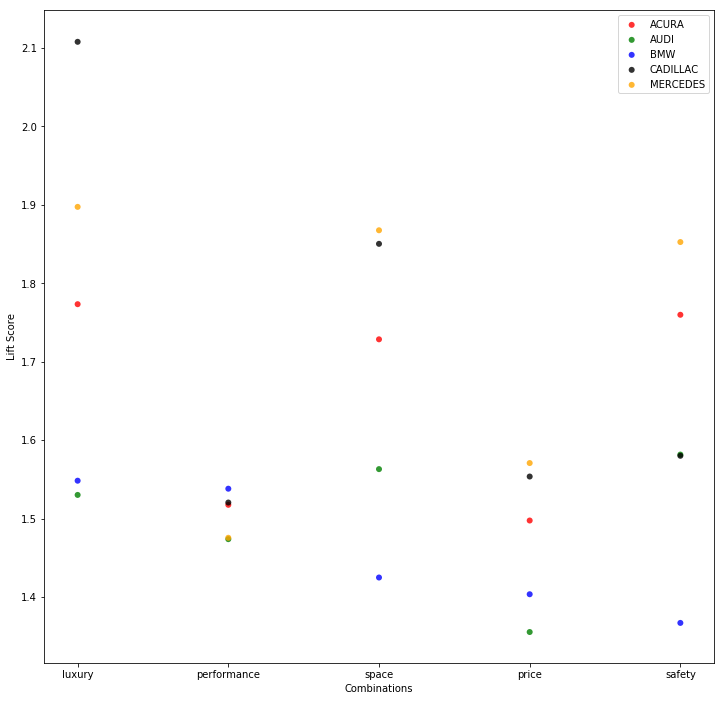

In [393]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
colors = ("red", "green", "blue","black","orange")
groups = plotarr.keys()

for lift, color, group in zip(plotarr, colors, groups):
#     plt.scatter(attributeList,plotarr[lift])
#     ax.scatter(attributeList, plotarr[lift])
    ax.scatter(attributeList, plotarr[lift], alpha=0.8, c=color, edgecolors='none', label=group)

plt.xlabel('Combinations')
plt.ylabel('Lift Score')
plt.legend(loc=1)
plt.show()